# To run DESI GPHOD

In [2]:
#Author: Shadab Alam
#To create the UNIT mocks matching DESI ELG
from __future__ import print_function
#To make the plots inline otherwise it will make seperate figure
%matplotlib inline 
#for high resolution plot outputs
%config InlineBackend.figure_format = 'retina'


import os
#To import the the functions for sampling from my directory
import sys

import numpy as np
import pylab as pl

import yaml

from astropy.coordinates import SkyCoord,ICRS
from astropy import units

import matplotlib
matplotlib.rcParams.update({'font.size': 22, 'font.family': 'serif'})

In [3]:
def sbatch_sh(comm,jobname,ncpu_need=16,outsh='',time_hr=48):
    
    machine='haswell'
    qos='shared'
    with open(outsh,'w') as fout:
        fout.write('#!/bin/bash\n')
        fout.write('#SBATCH -C %s\n'%machine)
        fout.write('#SBATCH -q %s\n'%qos)

        fout.write('#SBATCH --nodes=1\n')
        fout.write('#SBATCH --ntasks=1\n')
        fout.write('#SBATCH --cpus-per-task=%d\n'%ncpu_need)



        fout.write('#SBATCH --time=%d:00:00\n'%time_hr)


        fout.write('#SBATCH -J %s\n'%(jobname))
        fout.write('#SBATCH -e e%s\n'%(jobname))
        
        fout.write('source activate nbodykit3-env\n\n')
        
        fout.write(comm+'\n')
    
    
    return 'sbatch %s'%('/'.join(outsh.split('/')[-2:]))

def snap2redshift_scale(snap_in):
    
    'map snap to redshift and scale factor'
    #open the sim snapshot list
    snapshot_list_file='/global/homes/s/shadaba/Projects/MultiHODFitter/UNITSIM_mocks/unitsim_steps.txt'
    data=np.loadtxt(snapshot_list_file)
    
    ret_float=False
    if(not (isinstance(snap_in,list) or isinstance(snap_in,np.ndarray))):
        snap_in=[snap_in]
        ret_float=True
        
    redshift=[];scale=[]
    for snap in snap_in:
        index=np.where(data[:,0]==snap)[0][0]
        redshift.append(data[index,1])
        scale.append(data[index,2])
        
    if(ret_float):
        return redshift[0], scale[0]
    else:
        return redshift, scale

for snap in np.arange(107,109):
    print(snap,snap2redshift_scale(snap))#79,92,93,94,95,96,97,103,105,112,124,123,127,128]))

107 (0.5924, 0.628)
108 (0.5574, 0.6421)


In [10]:
def HODroot(idic,fixed_pars={}):
    outdir='/global/cscratch1/sd/shadaba/sv3/HOD_chains/'
    outroot='%sGPHOD_%s_snap%d_%s_slim-%4.2f-%4.2f'%(idic['tracer'],idic['sim'],idic['snap'],idic['sky'],
                            idic['wedge_slim'][0],idic['wedge_slim'][1])
    
    wedgetag='wed'
    for ww in idic['wedge_use']:
        wedgetag='%s%d'%(wedgetag,ww)
    outroot=outroot+wedgetag
    
    #any fixed parameter
    fixtag=''
    for tt,tkey in enumerate(fixed_pars.keys()):
        if(tt==0):
            fixtag='_fix'
        fixtag=fixtag+'-%s'%tkey
    
    outroot=outroot+fixtag
    
    if(idic['use_bias']):
        outroot=outroot+'_blin'
    
    return outdir,outdir+outroot

def get_wedge_file(tracer='LRG',sky='N',snap=100):
    '''get the wedge file name'''
    zsel_dic={'BGS_ANY':[[0.1,0.3],[0.2,0.4],[0.3,0.5]],#[0.1,0.5],
              'LRG':[[0.32,0.6],[0.6,0.8],[0.8,1.05]],#[0.6,1.05],
              'ELG':[[0.6,0.8],[0.8,1.05],[1.05,1.3],[1.3,1.6]],#,[0.6,1.05]],#[0.8,1.6],
              #'QSO':[[0.6,0.8],[0.8,1.05],[1.05,1.30],[1.3,1.6],[1.6,2.1]]#,[0.6,1.05]]#[0.8,2.1],
              'QSO':[[0.8,2.1]]
             }
    
    njn_dic={'N':120,'S':120,'NS':240}
    
    #get the redshift of the snapshot
    redshift,scale=snap2redshift_scale(snap)
    zoptions=zsel_dic[tracer] #options to choose from in redshift bin
    if(tracer!='BGS'): #find the correct bin
        if(redshift<=zoptions[0][0]):
            zchoose=zoptions[0]
        elif(redshift>=zoptions[-1][1]):
            zchoose=zoptions[-1]
        else:
            for zbin in zoptions:
                if(redshift>zbin[0] and redshift<zbin[1]):
                    zchoose=zbin
                    break        
    else:
        raise VALUEERROR('Not implemented')
              
    wedge_dir='/global/cfs/cdirs/desi/users/shadaba/sv3/XI/XI2D/'
    
    wedge_file='Wedge%s_%s_CLUSTERING_wcompEdWsys_z1z2_%s-%s_angup-logrmu-NJN-%s.txt'%(tracer,sky,
                                                                    str(zchoose[0]),str(zchoose[1]),njn_dic[sky])
        
    return wedge_dir+wedge_file
              
              
def update_config_file(tracer='LRG',sky='N',sim='UNIT',HODmodel='SHOD',snap=101,wedge_use=[1,2],wedge_slim=[0,3],fixed_pars={},
                       use_bias=False,ref_ini=None,action=True):
    '''updates the ini file for HOD fitting
    setting action to False doesnt create the ini files but simply returns the file name etc'''
    
    if(ref_ini is None):
        if(tracer in ['LRG','QSO','BGS_ANY']):
            ref_ini='/global/homes/s/shadaba/Projects/easymcmc/examples/GP_HOD/GPHOD.yaml'
        elif(tracer in ['ELG']):
            ref_ini='/global/homes/s/shadaba/Projects/easymcmc/examples/GP_HOD/GPHOD_ELG.yaml'
    
    #redshift,scale=snap2redshift_scale(np.array([snap]))
    replace_dic={'HODmodel':HODmodel,'snap':snap,'sim':sim,'sky':sky,
                 'tracer':tracer,
                 'initialize':'uniform',
                 'wedge_slim':wedge_slim,
                 'use_bias':use_bias,
                 'wedge_use':wedge_use,
                 'Sampler': {'name': 'emcee', 'nsteps': 2000,'nwalkers': 400}
                }
    
    assert(replace_dic['use_bias']==False) #The linear bias has not been implemented yet
    
    #get the output file names
    replace_dic['outdir'],replace_dic['outroot']=HODroot(replace_dic,fixed_pars=fixed_pars)
                
    #get the wedge measurement file names
    replace_dic['wedge_file']=get_wedge_file(tracer=tracer,sky=sky,snap=snap)
        
        
    
    outini=wdir+'tmp_Init/%s.yaml'%(replace_dic['outroot'].split('/')[-1])
    

    
    with open(ref_ini) as file:
        # The FullLoader parameter handles the conversion from YAML
        # scalar values to Python the dictionary format
        cfg = yaml.load(file, Loader=yaml.FullLoader)


    #update general settings
    for tt,tkey in enumerate(replace_dic.keys()):
        cfg[tkey]=replace_dic[tkey]

    #apply any fixpar settings
    for tt,tkey in enumerate(fixed_pars.keys()):
        cfg['Parameters'][tkey]['fixed']=True
        cfg['Parameters'][tkey]['default']=fixed_pars[tkey]

    if(action):
        with open(outini, 'w') as yamlfile:
            data = yaml.dump(cfg, yamlfile,default_flow_style=True)
            #print("Write successful",outini)    
                
    return outini,replace_dic,cfg

In [15]:


wdir='/global/u1/s/shadaba/Projects/easymcmc/'
#fixed_pars={'LMcut':13,'LM1':-10}
fixed_pars={}   

sim='UNIT'

tracer='ELG'
#tracer='LRG'
#tracer='QSO'
#tracer='BGS_ANY'

#setting action=True will create the necessary ini and slurm files for the jobs
action=True
#action=False

if(tracer in ['ELG']):
    HODmodel='HMQ'
else:
    HODmodel='SHOD'
    
if(tracer=='LRG'):
    sky='NS'
    snap_list=np.arange(85,118)
    wedge_use=[1,2]
    #fixed_pars={'gammaHV':1.0,'gammaIHV':1.0,'fconc':1.0,'fradsat':1.0,'kappa':2}
    fixed_pars={'gammaHV':1.0}
    #fixed_pars={}
elif(tracer=='ELG'):
    sky='NS'
    snap_list=np.arange(80,110)
    wedge_use=[1,2]
    fixed_pars={'gammaHV':1.0}
elif(tracer=='QSO'):
    sky='NS'
    snap_list=np.arange(79,112)
    wedge_use=[1,2]
    fixed_pars={'gammaHV':1.0}
elif(tracer=='BGS_ANY'):
    sky='NS'
    snap_list=np.arange(107,129)
    wedge_use=[1,2]
    fixed_pars={'gammaHV':1.0}
else:
    raise VALUEERROR
 
#overriding the snap list
#print('overriding the snap list for testing')
#snap_list=[128]

for ss,snap in enumerate(snap_list):
    outini,rpdic,cfg=update_config_file(tracer=tracer,sky=sky,sim=sim,HODmodel=HODmodel,snap=np.int(snap),
                        wedge_use=wedge_use,wedge_slim=[0,3],
                       fixed_pars=fixed_pars,use_bias=False,ref_ini=None,action=action)
    
    if(action):
        comm='cd %s\n\n'%(wdir)
        comm=comm+'python mcmc_main.py -config_file %s -action 1'%(outini)
        jobname='s%d-%s'%(snap,HODmodel)
        outsh=wdir+'tmpsh/%s.sh'%(outini.split('/')[-1][:-5])
        res=sbatch_sh(comm,jobname,ncpu_need=4,outsh=outsh,time_hr=10)
        print(res)
print('done')

sbatch tmpsh/ELGGPHOD_UNIT_snap80_NS_slim-0.00-3.00wed12_fix-gammaHV.sh
sbatch tmpsh/ELGGPHOD_UNIT_snap81_NS_slim-0.00-3.00wed12_fix-gammaHV.sh
sbatch tmpsh/ELGGPHOD_UNIT_snap82_NS_slim-0.00-3.00wed12_fix-gammaHV.sh
sbatch tmpsh/ELGGPHOD_UNIT_snap83_NS_slim-0.00-3.00wed12_fix-gammaHV.sh
sbatch tmpsh/ELGGPHOD_UNIT_snap84_NS_slim-0.00-3.00wed12_fix-gammaHV.sh
sbatch tmpsh/ELGGPHOD_UNIT_snap85_NS_slim-0.00-3.00wed12_fix-gammaHV.sh
sbatch tmpsh/ELGGPHOD_UNIT_snap86_NS_slim-0.00-3.00wed12_fix-gammaHV.sh
sbatch tmpsh/ELGGPHOD_UNIT_snap87_NS_slim-0.00-3.00wed12_fix-gammaHV.sh
sbatch tmpsh/ELGGPHOD_UNIT_snap88_NS_slim-0.00-3.00wed12_fix-gammaHV.sh
sbatch tmpsh/ELGGPHOD_UNIT_snap89_NS_slim-0.00-3.00wed12_fix-gammaHV.sh
sbatch tmpsh/ELGGPHOD_UNIT_snap90_NS_slim-0.00-3.00wed12_fix-gammaHV.sh
sbatch tmpsh/ELGGPHOD_UNIT_snap91_NS_slim-0.00-3.00wed12_fix-gammaHV.sh
sbatch tmpsh/ELGGPHOD_UNIT_snap92_NS_slim-0.00-3.00wed12_fix-gammaHV.sh
sbatch tmpsh/ELGGPHOD_UNIT_snap93_NS_slim-0.00-3.00wed12_fix-gam

In [1]:
cfg['outroot']

NameError: name 'cfg' is not defined

In [22]:

#froot='/global/cscratch1/sd/shadaba/sv3/HOD_chains/LRGGPHOD_UNIT_snap106_N_slim-0.00-3.00wed12_fix-gammaHV-gammaIHV-fconc-fradsat-kappa'
#froot='/global/cscratch1/sd/shadaba/sv3/HOD_chains/LRGGPHOD_UNIT_snap85_N_slim-0.00-3.00wed12_fix-gammaHV-gammaIHV-alpha-fconc-fradsat-sigma-kappa'
#froot='/global/cscratch1/sd/shadaba/sv3/HOD_chains/ELGGPHOD_UNIT_snap95_N_slim-0.00-3.00wed12_fix-gammaHV'
froot='/global/cscratch1/sd/shadaba/sv3/HOD_chains/QSOGPHOD_UNIT_snap95_NS_slim-0.00-3.00wed12_fix-gammaHV'


bfit_this,stat_this=get_bestfit(froot)
print(bfit_this,stat_this)
print('done')


Before/After:  800000 800000
{'weight': 1.0, 'loglike': -2.14350227, 'LM1': 14.0927463, 'LMcut': 11.9295532, 'alpha': 1.99040043, 'fconc': 1.34949383, 'fradsat': 0.424689531, 'gammaIHV': 0.500581806, 'kappa': 0.0126789134, 'sigma': 1.38516216, 'Ngal': 5000872.36, 'bias': 1.37562735, 'gammaHV': 1.0} {'mu': {'weight': 1.0, 'loglike': -6.084143259115424, 'LM1': 14.216756759046998, 'LMcut': 12.350758931252752, 'alpha': 1.309886389352597, 'fconc': 1.40213621651358, 'fradsat': 1.3123193824301616, 'gammaIHV': 0.88546860814411, 'kappa': 1.3352252691430038, 'sigma': 1.7972568637762778, 'Ngal': 5984606.575499949, 'bias': 1.35646817656235, 'gammaHV': 1.0}, 'sigma': {'weight': 0.0, 'loglike': 1.5633732940518703, 'LM1': 0.5091063645165929, 'LMcut': 0.8499286355906073, 'alpha': 0.5231137778380983, 'fconc': 0.7966953822367465, 'fradsat': 0.926150020769775, 'gammaIHV': 0.43034771657328097, 'kappa': 0.8613924604625406, 'sigma': 0.7905587023341719, 'Ngal': 4815706.050385787, 'bias': 0.08965310520818376,

In [9]:
def load_def_values(rootin):
    fname=rootin+'.defpar'
    tlines=open(fname,'r').readlines()
    def_par={}
    for tt,tline in enumerate(tlines):
        tspl=tline.split()
        def_par[tspl[0]]=np.float(tspl[1])
    
    return def_par

def get_bestfit(froot,const_dic={}):
    #returns the bestfit parameters
    pmap={}
    rev_map={}
    tcc=0
    with open(froot+'.txt','r') as fin:
        while(True):
            tcc=tcc+1
            tline= fin.readline()
            if('#pars:' in tline):
                tspl=tline[6:-1].split(',')
                for tt,ts in enumerate(tspl):
                    pmap[tt]=ts.strip()
                    rev_map[ts.strip()]=tt
                    
                
                break
            if(tcc>50):
                break
        
    
    tchain=np.loadtxt(froot+'.txt')
    
    ind=np.ones(tchain.shape[0],dtype=bool)
    #apply any constrain
    for tt,tkey in enumerate(const_dic.keys()):
        ymin=const_dic[tkey][0]
        ymax=const_dic[tkey][1]
        if(ymin is not None):
            ind=ind*(tchain[:,rev_map[tkey]]>=ymin)
        if(ymax is not None):
            ind=ind*(tchain[:,rev_map[tkey]]<=ymax)
    print('Before/After: ',ind.size,ind.sum())    
    tchain=tchain[ind,:]
    
    indmin=np.argmax(tchain[:,1])
    bfit_arr=tchain[indmin,:]
       
    #get the errors
    bfit_dic={}
    stat_dic={'mu':{},'sigma':{}}
    burnin=np.int(0.5*tchain.shape[0])
    for ii in range(0,tchain.shape[1]):
        stat_dic['mu'][pmap[ii]]=np.mean(tchain[burnin:,ii])
        stat_dic['sigma'][pmap[ii]]=np.std(tchain[burnin:,ii])
        bfit_dic[pmap[ii]]=tchain[indmin,ii]
    
    #load the default values
    def_par=load_def_values(froot)
    #add any missing value in bestfit by defualt value
    for tt,tkey in enumerate(def_par.keys()):
        if(tkey not in bfit_dic.keys()):
            bfit_dic[tkey]=def_par[tkey]
            stat_dic['mu'][tkey]=def_par[tkey]
            stat_dic['sigma'][tkey]=0
                
    return bfit_dic , stat_dic
    
bfit_dic={}
stat_dic={'mu':{},'sigma':{}}
setup_def=True
for ss,snap in enumerate(snap_list):
    outini,rpdic,cfg=update_config_file(tracer=tracer,sky=sky,sim=sim,HODmodel=HODmodel,snap=np.int(snap),wedge_use=[1,2],wedge_slim=[0,3],
                       fixed_pars=fixed_pars,use_bias=False,ref_ini=None)
    

        
    try:
        bfit_this,stat_this=get_bestfit(cfg['outroot'],const_dic=constraint_dic)
    except:
        print(snap,'failed')
        continue
        
    if(setup_def):
        def_par=load_def_values(cfg['outroot'])
        setup_def=False
        
    if(ss==0):
        bfit_dic['snap']=[snap]
    else:
        bfit_dic['snap'].append(snap)
      
    print(snap,-2.0*bfit_this['loglike'],bfit_this['Ngal'],bfit_this['bias'])
    for tt,tkey in enumerate(bfit_this.keys()):
        if(ss==0):
            bfit_dic[tkey]=[bfit_this[tkey]]
            stat_dic['mu'][tkey]=[stat_this['mu'][tkey]]
            stat_dic['sigma'][tkey]=[stat_this['sigma'][tkey]]
        else:
            bfit_dic[tkey].append(bfit_this[tkey])
            stat_dic['mu'][tkey].append(stat_this['mu'][tkey])
            stat_dic['sigma'][tkey].append(stat_this['sigma'][tkey])
            
    
    
print('done')

Before/After:  800000 338028
100 3.81892954 1586904.15 1.92324373
done


In [5]:
if(tracer=='LRG'):
    constraint_dic={'Ngal':[7e-4*1e9,None],'bias':[None,2.5]}
elif(tracer=='ELG'):
    constraint_dic={'Ngal':[1e-3*1e9,1e-2*1e9]}
elif(tracer=='QSO'):
    constraint_dic={}
    
print(tracer,constraint_dic)

LRG {'Ngal': [700000.0, None], 'bias': [None, 2.5]}


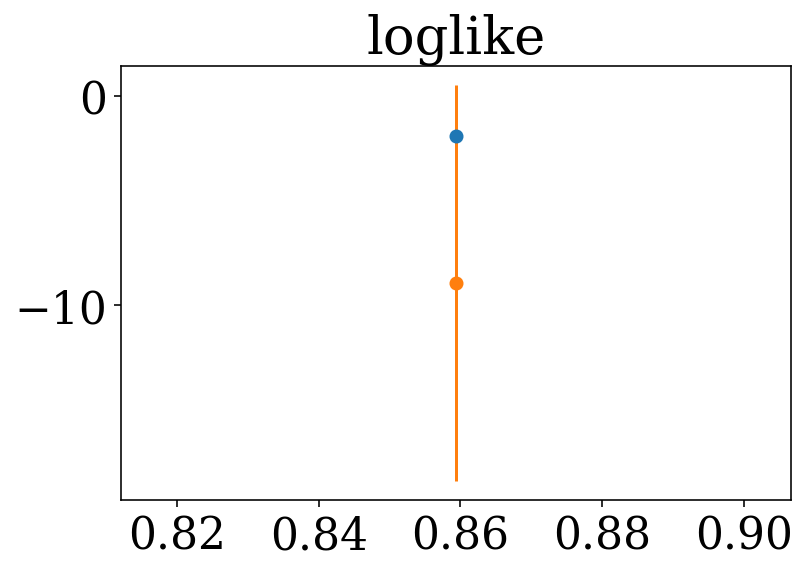

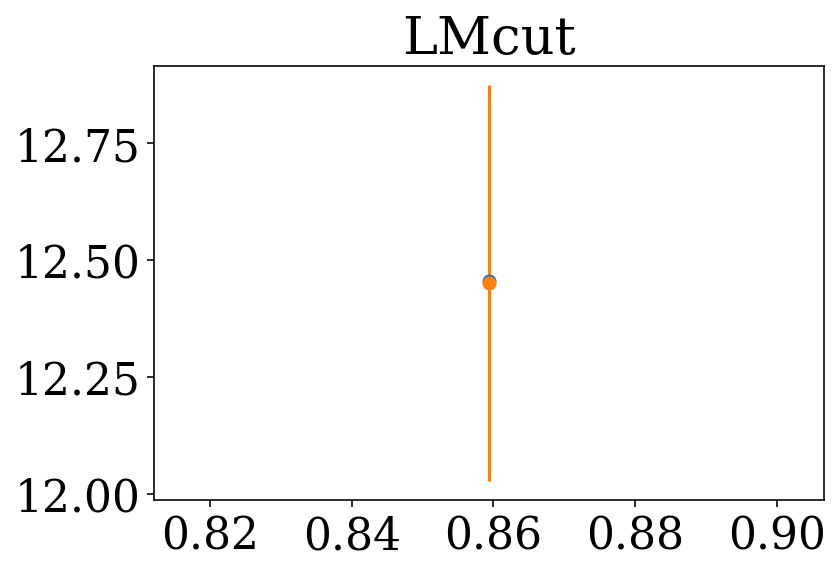

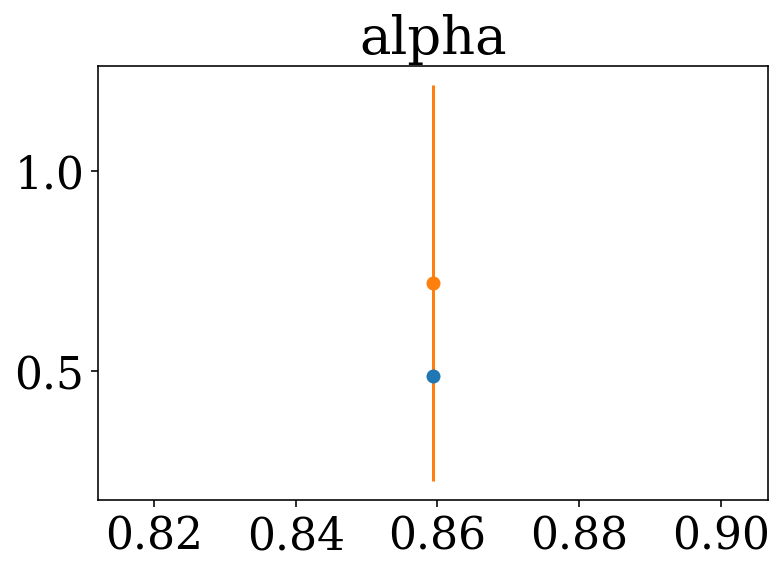

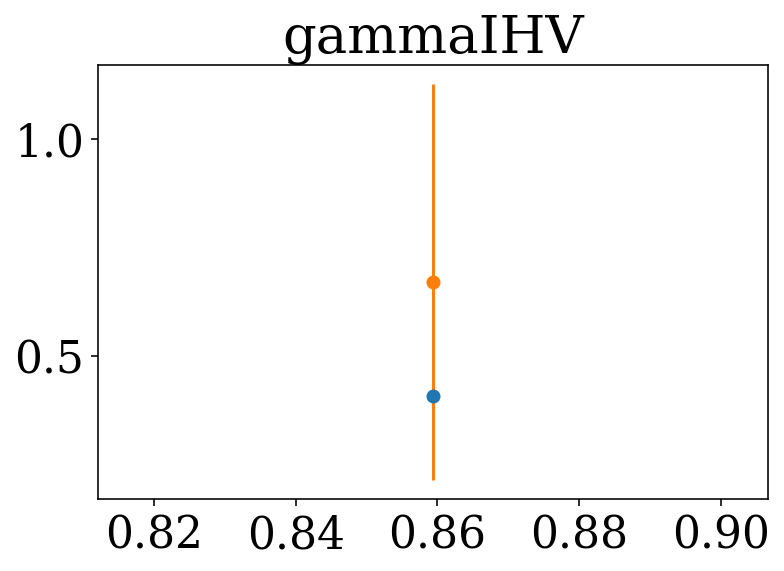

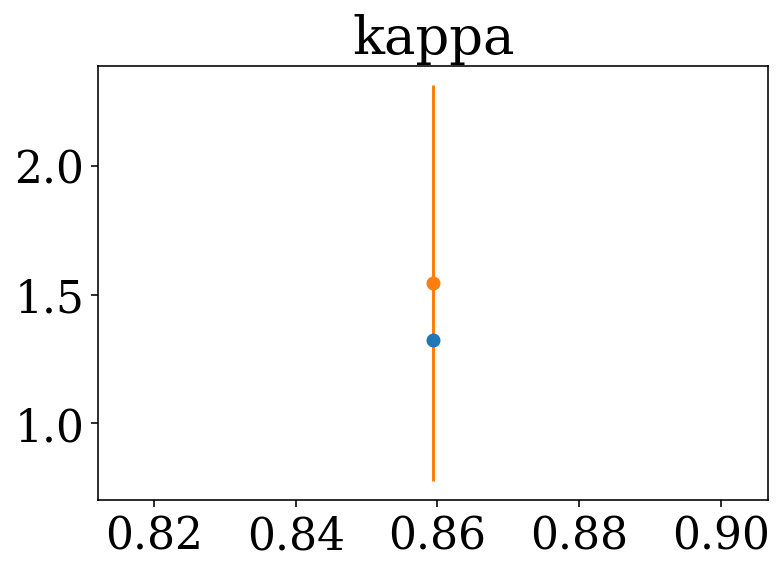

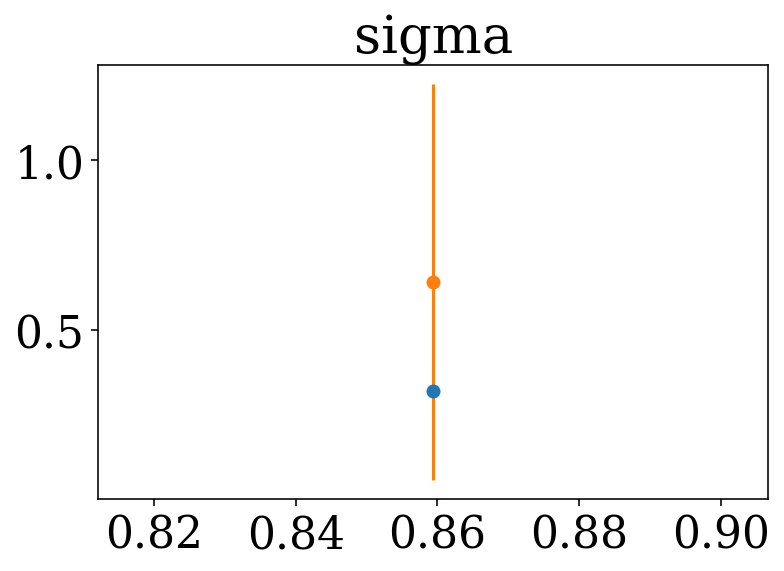

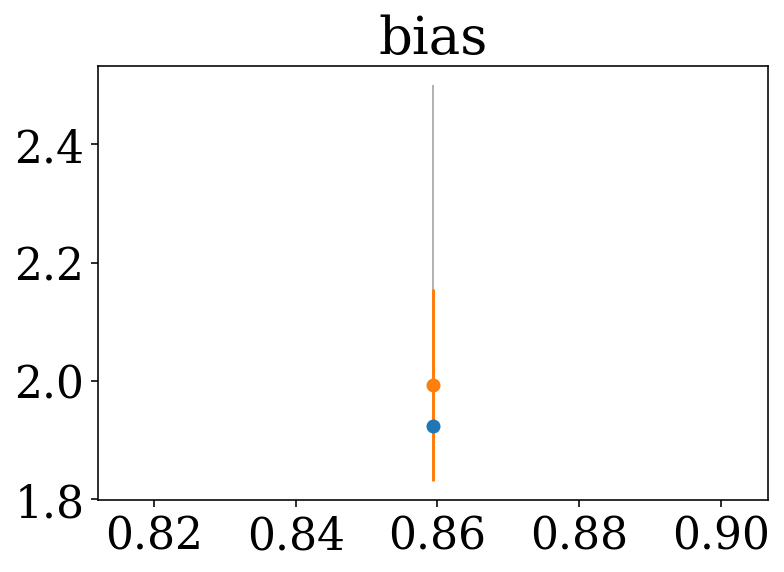

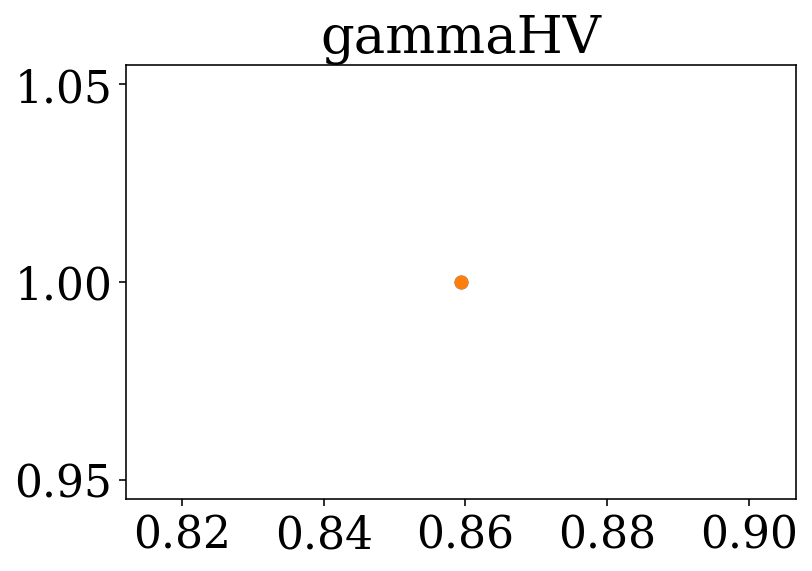

In [10]:
bfit_dic['redshift'],bfit_dic['scale']=snap2redshift_scale(bfit_dic['snap'])
for tt,tkey in enumerate(bfit_dic.keys()):
    if(tkey in ['snap','redshift','scale','weight']):
        continue
    pl.figure();pl.title(tkey)
    pl.plot(bfit_dic['redshift'],bfit_dic[tkey],'o-')
    pl.errorbar(bfit_dic['redshift'],stat_dic['mu'][tkey],yerr=stat_dic['sigma'][tkey],fmt='o')
    
    if(tkey in ['Ngal']):
        pl.yscale('log')
    
    #plot the constraint
    if(tkey in constraint_dic.keys()):
        xval=np.array(bfit_dic['redshift'])     
        if(constraint_dic[tkey][0] is None):
            ymin=xval*0+min(bfit_dic[tkey])
        else:
            ymin=xval*0+constraint_dic[tkey][0]
            
        if(constraint_dic[tkey][1]is None):
            ymax=xval*0+max(bfit_dic[tkey])
        else:
            ymax=xval*0+constraint_dic[tkey][1]
            
        #print(ymin,ymax)
        pl.fill_between(xval,ymin,ymax,color='k',alpha=0.3)
        #pl.plot(xval,yval,'k--',lw=2)
    
    
    

In [345]:
bfit_dic['snap']

[90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 106]

# To Generate the galaxy catalogs

In [6]:
def prepHOD_comm(snap,bfit_dic,def_par,HODmodel='SHOD',run=True,Lbox=1000,get_pk=False):
    '''This prepares the HOD command to be executed for given tracer and halo catalogue
    Mr is only used for BGS in version'''
    
    if(snap>=112 or snap<79):
        halo_dir='/global/cscratch1/sd/shadaba/UNITSIM/fixedAmp_004_3Gpc_lowres/ROCKSTAR/'
        #fixedAmp_004_3Gpc_lowres/ROCKSTAR/
    else:
        halo_dir='/global/cfs/cdirs/desi/cosmosim/UNITSIM/fixedAmp_004_3Gpc_lowres/ROCKSTAR/'
    
    comm_exec=' /global/u1/s/shadaba/Projects/HODFitter/HOD_populate.py -halo_type UNITSIM -Lbox %d -satelite scalers '%Lbox
    #comm_exec=' ../HODMultiHOD_populate.py -halo_type UNITSIM -Lbox %d -satelite scalers '%Lbox
    
    redshift,scale=snap2redshift_scale(snap)
    
    cex=' -redshift %4.2f -xispace Real -subhalo 0 '%(redshift)
    if(HODmodel=='SHOD'):
        cex=cex+' -HODmodel normal'
    elif(HODmodel=='HMQ'):
        cex=cex+' -HODmodel ELG'
    
    
    for tt,tkey in enumerate(def_par.keys()):
        cex=cex+' -%s %5.3f'%(tkey,bfit_dic[tkey])
    
    #galaxy catalogue output file
    Gcatdir=outdir+'%s_Gcat/'%(sim)
    
    #create directory to write galaxy catalog if doesn't exists
    if(not os.path.isdir(Gcatdir)):
        os.mkdir(Gcatdir)
      
    if(sim=='UNIT'):
        sub_list=np.arange(0,27)
       
    comm_coll=''
    gcat_files=[]
    for ss,sub in enumerate(sub_list):
        halofile=halo_dir+'out_%dp.list.sub%d'%(snap,sub)
        outroot='%s%s_snap%d.gcat.sub%d'%(Gcatdir,tracer,snap,sub)
            
        gcat_file=outroot+'.gcat'
        gcat_files.append(gcat_file)
        
        if(os.path.isfile(gcat_file)):
            print('gcat exists:',gcat_file)
            continue
        
        if(not os.path.isfile(halofile)):
            print('halos not found:',halofile)
            continue
            
        cex_this=cex+' -hcat %s -outroot %s '%(halofile,outroot)
        
        comm_final=comm_exec+cex_this
    
        if(run==True):
            print(comm_final)
            #execute the command
            !python $comm_final
        else:
            #print('python ',comm_final)
            comm_coll=comm_coll+'\n\npython '+comm_final
    
    if(0):
        #measure wp for the purpose of bias measurement
        wpcomm='python Measure_wp_gcat.py  -Lbox 1000 -outroot test-wp -pimax 40 '
        wpcomm=wpcomm+'-logrper -1.0 1.477 10 -subsamp 1.0'
        wpcomm='-cat %s'%(gcat_file)

        os.system(wpcomm)

        #wpfile='test-wp.wp.real'
        #wpmodel=np.loadtxt(wpfile)
    if(get_pk==True):
        get_pk(gcat_file,zspace='rsd',Ngrid=512,Lbox=1000,run=run,fout=None)
        
    return comm_coll,gcat_files #,wpmodel

In [29]:
#directory to store the galaxy catalog
outdir='/global/cfs/cdirs/desi/cosmosim/mocks_SV3/v1/UNITSIM/'

gcat_dic={}
if(tracer=='LRG'):
    snap_hod=np.arange(85,112)
elif(tracer=='ELG'):
    snap_hod=np.arange(90,110)
    
for snap in snap_hod:
    ind=np.where(np.array(bfit_dic['snap'])==snap)[0]
    if(ind.size==0):
        print('missing snap=%d'%snap)
        continue
    elif(ind.size>1):
        print('Error Multiple entry for snap=%d'%snap,ind)
        raise VALUERROR
    else:
        ind=ind[0]

    bfit_this={}
    for tt,tkey in enumerate(def_par.keys()):
        bfit_this[tkey]=bfit_dic[tkey][ind]

    wdir='/global/u1/s/shadaba/Projects/HODFitter/'
    comm_coll,gcat_dic[snap]=prepHOD_comm(snap,bfit_this,def_par,run=False,Lbox=3000,get_pk=False)
    jobname='%sHOD%d-%s'%(tracer,snap,HODmodel)
    outsh=wdir+'tmpsh/HOD%d-%s-%s.sh'%(snap,HODmodel,tracer)

    comm_coll='cd %s\n\n%s'%(wdir,comm_coll)
    res=sbatch_sh(comm_coll,jobname,ncpu_need=5,outsh=outsh,time_hr=10)
    print(res)

sbatch tmpsh/HOD90-SHOD-QSO.sh
sbatch tmpsh/HOD91-SHOD-QSO.sh
sbatch tmpsh/HOD92-SHOD-QSO.sh
sbatch tmpsh/HOD93-SHOD-QSO.sh
sbatch tmpsh/HOD94-SHOD-QSO.sh
sbatch tmpsh/HOD95-SHOD-QSO.sh
sbatch tmpsh/HOD96-SHOD-QSO.sh
sbatch tmpsh/HOD97-SHOD-QSO.sh
sbatch tmpsh/HOD98-SHOD-QSO.sh
sbatch tmpsh/HOD99-SHOD-QSO.sh
sbatch tmpsh/HOD100-SHOD-QSO.sh
sbatch tmpsh/HOD101-SHOD-QSO.sh
sbatch tmpsh/HOD102-SHOD-QSO.sh
sbatch tmpsh/HOD103-SHOD-QSO.sh
sbatch tmpsh/HOD104-SHOD-QSO.sh
missing snap=105
sbatch tmpsh/HOD106-SHOD-QSO.sh
sbatch tmpsh/HOD107-SHOD-QSO.sh
sbatch tmpsh/HOD108-SHOD-QSO.sh
sbatch tmpsh/HOD109-SHOD-QSO.sh


In [13]:
wdir='/global/u1/s/shadaba/Projects/HODFitter/'
outdir='/global/cscratch1/sd/shadaba/UNIT_Gcat_test/'
bfit_this={
  'LM1': 13.2755702,
  'LMcut': 12.7735041,
  'alpha': 0.348287554,
  'fconc': 1.19654303,
  'fradsat': 1.17783076,
  'gammaIHV': 0.623311186,
  'kappa': 1.91434129,
  'sigma': 0.795044299,
  'gammaHV': 1.0}
def_par=bfit_this
sim='UNIT'
tracer='LRG'
comm_coll,_=prepHOD_comm(100,bfit_this,def_par,HODmodel='SHOD',run=False,Lbox=3000,get_pk=False)
print(comm_coll)



python  /global/u1/s/shadaba/Projects/HODFitter/HOD_populate.py -halo_type UNITSIM -Lbox 3000 -satelite scalers  -redshift 0.86 -xispace Real -subhalo 0  -HODmodel normal -LM1 13.276 -LMcut 12.774 -alpha 0.348 -fconc 1.197 -fradsat 1.178 -gammaIHV 0.623 -kappa 1.914 -sigma 0.795 -gammaHV 1.000 -hcat /global/cfs/cdirs/desi/cosmosim/UNITSIM/fixedAmp_004_3Gpc_lowres/ROCKSTAR/out_100p.list.sub0 -outroot /global/cscratch1/sd/shadaba/UNIT_Gcat_test/UNIT_Gcat/LRG_snap100.gcat.sub0 

python  /global/u1/s/shadaba/Projects/HODFitter/HOD_populate.py -halo_type UNITSIM -Lbox 3000 -satelite scalers  -redshift 0.86 -xispace Real -subhalo 0  -HODmodel normal -LM1 13.276 -LMcut 12.774 -alpha 0.348 -fconc 1.197 -fradsat 1.178 -gammaIHV 0.623 -kappa 1.914 -sigma 0.795 -gammaHV 1.000 -hcat /global/cfs/cdirs/desi/cosmosim/UNITSIM/fixedAmp_004_3Gpc_lowres/ROCKSTAR/out_100p.list.sub1 -outroot /global/cscratch1/sd/shadaba/UNIT_Gcat_test/UNIT_Gcat/LRG_snap100.gcat.sub1 

python  /global/u1/s/shadaba/Project

In [ ]:
python /global/u1/s/shadaba/Projects/MultiHODFitter/Measure_wp_gcat.py -Lbox 1000 -cat_type UNIT -rsd zRSD -cat /global/cscratch1/sd/shadaba/UNIT_Gcat_test/UNIT_Gcat/LRG_snap100.gcat.sub0.gcat -outroot /global/cscratch1/sd/shadaba/UNIT_Gcat_test/WP/UNIT_Gcat/LRG_snap100.sub0 -redshift 0.8594 

In [45]:
#Now merge the files
def create_merged_file(ofiles):
    '''This writes a single file with merged output
    if ofiles has only one entry then it simply return the file name as it is'''
    
    if(len(ofiles)==1):
        return ofiles[0]
    
    #outfname_spl=ofiles[0].split('/')
    #outfname='/'.join(outfname_spl[:-1])+'.gcat'
    outfname=ofiles[0].split('.sub')[0]
    
    #keep it in a seperate directory
    tspl=outfname.split('/')
    tspl[-2]=tspl[-2]+'_comb'
    outfname='/'.join(tspl)
    
    if(os.path.isfile(outfname)):
        print('Exists: outfile: ',outfname)
        print('quiting! doing nothing: To overwrite first delete the outfile')
        return
    
    print('creating file: ',outfname)

    fout=open(outfname,'w')
    for ff,fname in enumerate(ofiles):
        print('merging',fname.split('/')[-1])
        if(ff==0):
            #read the file header
            fin=open(fname,'r')
            while(True):
                tline=fin.readline()
                if(tline[0]=='#'):
                    fout.write(tline)
                else:
                    fin.close()
                    break
          
        tmpdata=np.loadtxt(fname)
        np.savetxt(fout,tmpdata)
        
    
    fout.close()
    
    return outfname

def generate_file_list(tracer,snap):
    hod_dir='/global/cfs/cdirs/desi/cosmosim/mocks_SV3/v1/UNITSIM/UNIT_Gcat/'
    fname=lambda tracer,snap,sub: '%s%s_snap%d.gcat.sub%d.gcat'%(hod_dir,tracer,snap,sub)
    
    flist=[]
    for ii in range(0,27):
        tf=fname(tracer,snap,ii)
        if(not os.path.isfile(tf)):
            return None
        flist.append(tf)
        
    return flist

for snap in range(85,92):
    flist=generate_file_list('LRG',snap)
    if(flist is None):
        print('Incomplete catalogs')
    else:
        create_merged_file(flist)
        
print('done')

Exists: outfile:  /global/cfs/cdirs/desi/cosmosim/mocks_SV3/v1/UNITSIM/UNIT_Gcat_comb/LRG_snap85.gcat
quiting! doing nothing: To overwrite first delete the outfile
Exists: outfile:  /global/cfs/cdirs/desi/cosmosim/mocks_SV3/v1/UNITSIM/UNIT_Gcat_comb/LRG_snap86.gcat
quiting! doing nothing: To overwrite first delete the outfile
Exists: outfile:  /global/cfs/cdirs/desi/cosmosim/mocks_SV3/v1/UNITSIM/UNIT_Gcat_comb/LRG_snap87.gcat
quiting! doing nothing: To overwrite first delete the outfile
Exists: outfile:  /global/cfs/cdirs/desi/cosmosim/mocks_SV3/v1/UNITSIM/UNIT_Gcat_comb/LRG_snap88.gcat
quiting! doing nothing: To overwrite first delete the outfile
Exists: outfile:  /global/cfs/cdirs/desi/cosmosim/mocks_SV3/v1/UNITSIM/UNIT_Gcat_comb/LRG_snap89.gcat
quiting! doing nothing: To overwrite first delete the outfile
Exists: outfile:  /global/cfs/cdirs/desi/cosmosim/mocks_SV3/v1/UNITSIM/UNIT_Gcat_comb/LRG_snap90.gcat
quiting! doing nothing: To overwrite first delete the outfile
creating file:  

# Measure wp with redshift


In [56]:
def get_comm_wp(snap,tracer,sub=0):
    hod_dir='/global/cfs/cdirs/desi/cosmosim/mocks_SV3/v1/UNITSIM/UNIT_Gcat/'
    
    fname=lambda tracer,snap,sub: '%s%s_snap%d.gcat.sub%d.gcat'%(hod_dir,tracer,snap,sub)
    outroot=hod_dir+'WP/%s-snap%d-sub%d'%(tracer,snap,sub)
    redshift,scale=snap2redshift_scale(snap)
    
    wp_exe='python /global/u1/s/shadaba/Projects/MultiHODFitter/Measure_wp_gcat.py -Lbox 1000 -cat_type UNIT -rsd zRSD'
    wpcomm=wp_exe+' -cat %s -outroot %s -redshift %5.3f'%(fname(tracer,snap,sub),outroot,redshift)
    
    print(wpcomm)
    
    return wpcomm

res=get_comm_wp(107,'LRG',sub=0)
res=get_comm_wp(90,'ELG',sub=0)
res=get_comm_wp(90,'QSO',sub=0)
#-cat /global/cfs/cdirs/desi/cosmosim/mocks_SV3/v1/UNITSIM/UNIT_Gcat/LRG_snap100.gcat.sub0.gcat -outroot test 
#-cat_type UNIT -rsd zRSD -redshift 0.86

python /global/u1/s/shadaba/Projects/MultiHODFitter/Measure_wp_gcat.py -Lbox 1000 -cat_type UNIT -rsd zRSD -cat /global/cfs/cdirs/desi/cosmosim/mocks_SV3/v1/UNITSIM/UNIT_Gcat/LRG_snap107.gcat.sub0.gcat -outroot /global/cfs/cdirs/desi/cosmosim/mocks_SV3/v1/UNITSIM/UNIT_Gcat/WP/LRG-snap107-sub0 -redshift 0.592
python /global/u1/s/shadaba/Projects/MultiHODFitter/Measure_wp_gcat.py -Lbox 1000 -cat_type UNIT -rsd zRSD -cat /global/cfs/cdirs/desi/cosmosim/mocks_SV3/v1/UNITSIM/UNIT_Gcat/ELG_snap90.gcat.sub0.gcat -outroot /global/cfs/cdirs/desi/cosmosim/mocks_SV3/v1/UNITSIM/UNIT_Gcat/WP/ELG-snap90-sub0 -redshift 1.321
python /global/u1/s/shadaba/Projects/MultiHODFitter/Measure_wp_gcat.py -Lbox 1000 -cat_type UNIT -rsd zRSD -cat /global/cfs/cdirs/desi/cosmosim/mocks_SV3/v1/UNITSIM/UNIT_Gcat/QSO_snap90.gcat.sub0.gcat -outroot /global/cfs/cdirs/desi/cosmosim/mocks_SV3/v1/UNITSIM/UNIT_Gcat/WP/QSO-snap90-sub0 -redshift 1.321


In [47]:
#mv /global/cfs/cdirs/desi/cosmosim/mocks_SV3/v1/UNITSIM/UNIT_Gcat_comb/ /global/cfs/cdirs/desi/cosmosim/mocks_SV3/v1/UNITSIM/test


In [14]:
for snap in [80,90,100,105,107,110]:
    print(snap,snap2redshift_scale(snap))

80 (1.896, 0.3453)
90 (1.321, 0.4309)
100 (0.8594, 0.5378)
105 (0.6644, 0.6008)
107 (0.5924, 0.628)
110 (0.4899, 0.6712)


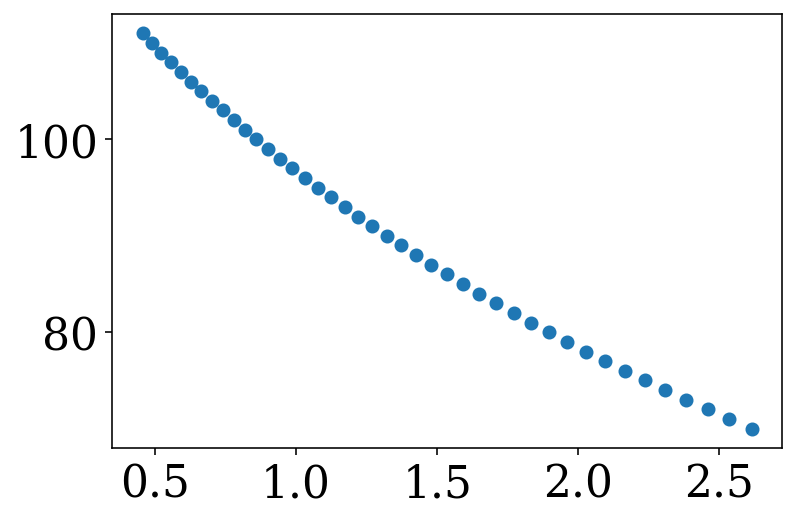

In [294]:
snap_in=np.arange(70,112)
redshift,scale=snap2redshift_scale(snap_in)
pl.plot(redshift,snap_in,'o')
#print(redshift,scale)

In [84]:
#!rm /global/u1/s/shadaba/Projects/easymcmc/tmpsh/*

In [30]:
import os

file_path = os.path.realpath(__file__)

NameError: name '__file__' is not defined

In [52]:
!cat /global/u1/s/shadaba/Projects/easymcmc/tmp_Init/GPHOD_UNIT_snap101_N_slim-0.00-3.00wed_fix-LMcut-LM1.yaml

{Cinterpolation: true, HODmodel: SHOD, Likelihood: {GPHOD: {logp: lnlike, path: examples/GP_HOD/logp.py}},
  LinearBias: {mean: 2.1, sigma: 0.015}, Parameters: {LM1: {default: -10, fixed: true,
      prior: {max: 15.0, min: 12.0, type: uniform}}, LMcut: {default: 13, fixed: true,
      prior: {max: 14.0, min: 11.0, type: uniform}}, alpha: {default: 0.5, fixed: false,
      prior: {max: 2.0, min: 0.001, type: uniform}}, fconc: {default: 0.5, fixed: false,
      prior: {max: 3.0, min: 0.001, type: uniform}}, fradsat: {default: 0.5, fixed: false,
      prior: {max: 3.0, min: 0.001, type: uniform}}, gammaHV: {default: 1.0, fixed: false,
      prior: {max: 2.0, min: 0.0, type: uniform}}, gammaIHV: {default: 1.0, fixed: false,
      prior: {max: 2.0, min: 0.0, type: uniform}}, kappa: {default: 0.5, fixed: false,
      prior: {max: 3.0, min: 0.001, type: uniform}}, sigma: {default: 0.5, fixed: false,
      prior: {max: 3.0, min: 0.0, type: uniform}}}, Sampler: {name: emcee, nsteps: 1000,
    

In [5]:
#!mkdir ../tmp_Init

In [298]:
import fitsio as F